# Training U-Net model
## 250 Epochs, No Dropout, Adam Optimizer, Learning Rate 1e-3

In [1]:
import sys
sys.path.append("..")
import os, re, glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from src import data,unet,unet_bn

Using TensorFlow backend.


In [2]:
from keras import utils
train_dir = "/home/ubuntu/TrainingSet"
weight_file = 'saved_models/endo_models/weights-250Epochs-BN-Adam3.hdf5'
epi_weight_file = 'saved_models/epi_models/weights-250Epochs-BN-Adam3.hdf5'
save_imgs_dir = 'images/train50050DrpAdam3/endo_images'
save_imgs_dir_epi = 'images/train50050DrpAdam3/epi_images'

images = []
inner_masks = []
outer_masks = []

patient_directories = sorted(glob.glob(os.path.join(train_dir, "patient*")))

for patient_dir in patient_directories:
    imgdata = data.ImageData(patient_dir)
    images += imgdata.labeled_images
    inner_masks += imgdata.endo_masks
    outer_masks += imgdata.epi_masks

images = np.asarray(images)[:,:,:,None].astype('float64')
i_masks = np.asarray(inner_masks)
o_masks = np.asarray(outer_masks)

dims = i_masks.shape
classes = len(set(i_masks[0].flatten()))
new_shape = dims + (classes,)
i_masks = utils.to_categorical(i_masks).reshape(new_shape)
o_masks = utils.to_categorical(o_masks).reshape(new_shape)

#i_masks_cropped=[]
#crop_x = 8

#for mask in i_masks:
#    i_masks_cropped.append(mask[0+crop_x//2:216-crop_x//2,:,:])

#print(i_masks[0].shape)
#print(i_masks_cropped[0].shape)

#i_masks_final = np.asarray(i_masks_cropped)



def normalize(x, epsilon=1e-7, axis=(1,2)):
    x -= np.mean(x, axis=axis, keepdims=True)
    x /= np.std(x, axis=axis, keepdims=True) + epsilon
    
normalize(images,axis=(1,2))

print("There are %d total training images." % len(images))
print("There are %d total inner masks." % len(inner_masks))
print("There are %d total outer masks." % len(outer_masks))

There are 243 total training images.
There are 243 total inner masks.
There are 243 total outer masks.


In [3]:
height,width,_ = images[0].shape
dropout = 0.0
unet_conv = unet_bn.UNet()

model_endo = unet_conv.get_unet(height=height, width=width, channels=1,features=32,steps=3,dropout=dropout,padding='same')
model_endo.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 216, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 216, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 216, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 216, 256, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

In [4]:
from keras.optimizers import Adam, SGD
from keras import backend as K

def dice_coef(y_true, y_pred):
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    intersection = K.sum(flat_y_true * flat_y_pred)
    return (2. * intersection + 1.) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + 1.)

def dice_coef_np(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + 1.) / (np.sum(y_true) + np.sum(y_pred) + 1.)


def pixelwise_crossentropy(y_true, y_pred, weights=[0.5,0.5], epsilon=1e-8):
    ndim = K.ndim(y_pred)
    ncategory = K.int_shape(y_pred)[-1]
    # scale predictions so class probabilities of each pixel sum to 1
    y_pred /= K.sum(y_pred, axis=(ndim-1), keepdims=True)
    y_pred = K.clip(y_pred, epsilon, 1-epsilon)
    w = K.constant(weights) * (ncategory / sum(weights))
    # first, average over all axis except classes
    cross_entropies = -K.mean(y_true * K.log(y_pred), axis=tuple(range(ndim-1)))
    return K.sum(w * cross_entropies)


def show_plots(history):    
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model dice')
    plt.ylabel('dice')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.imshow()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.imshow()
    plt.savefig(os.path.join(save_imgs_dir,"acc-loss-plot.png"))
model_endo.compile(optimizer=Adam(lr=1e-3),loss=[pixelwise_crossentropy],metrics=[dice_coef])

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from math import ceil

seed = 78

validation_split = 0.2

epochs = 250
batch_size = 32


split_index = int((1 - validation_split) * len(images))

train_steps = ceil(split_index / batch_size)
val_steps = ceil((len(images)-split_index )/batch_size)

train_images = images[:split_index]
train_inner_masks = i_masks[:split_index]
train_outer_masks = o_masks[:split_index]

validation_images = images[split_index:]
validation_inner_masks = i_masks[split_index:]
validation_outer_masks = o_masks[split_index:]


data_gen_args = dict(rotation_range=180,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.01,
                     fill_mode='nearest')

train_images_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**data_gen_args)


#seed = 1
#height,width,channels = train_images[0].shape
#print(train_images[0].shape)
#print(train_inner_masks[0].shape)
train_images_datagen.fit(train_images,augment=True,seed=seed)
train_masks_datagen.fit(train_inner_masks,augment=True,seed=seed)

train_images_generator = train_images_datagen.flow(train_images, y=None, seed=seed)
train_masks_generator = train_images_datagen.flow(train_inner_masks, y=None, seed=seed)


train_generator = zip(train_images_generator, train_masks_generator)

/usr/local/lib/python3.5/dist-packages/Keras-2.1.3-py3.5.egg/keras/preprocessing/image.py:722: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
/usr/local/lib/python3.5/dist-packages/Keras-2.1.3-py3.5.egg/keras/preprocessing/image.py:896: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).


In [7]:
checkpointer = ModelCheckpoint(filepath=weight_file, verbose=1, save_best_only=True)

hist = model_endo.fit_generator(train_generator,steps_per_epoch=train_steps,epochs=epochs,verbose=1,callbacks=[checkpointer],
                   validation_data=(validation_images,validation_inner_masks),validation_steps=val_steps)

Epoch 1/250
6/7 [========================>.....] - ETA: 2s - loss: 0.6478 - dice_coef: 0.5588
Epoch 00001: val_loss improved from inf to 2.61674, saving model to saved_models/endo_models/weights-250Epochs-BN-Adam3.hdf5
7/7 [==============================] - 19s 3s/step - loss: 0.6157 - dice_coef: 0.5755 - val_loss: 2.6167 - val_dice_coef: 0.3855
Epoch 2/250
6/7 [========================>.....] - ETA: 1s - loss: 0.2989 - dice_coef: 0.7595
Epoch 00002: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.2934 - dice_coef: 0.7643 - val_loss: 6.3299 - val_dice_coef: 0.3975
Epoch 3/250
6/7 [========================>.....] - ETA: 1s - loss: 0.2388 - dice_coef: 0.8085
Epoch 00003: val_loss improved from 2.61674 to 1.26920, saving model to saved_models/endo_models/weights-250Epochs-BN-Adam3.hdf5
7/7 [==============================] - 9s 1s/step - loss: 0.2408 - dice_coef: 0.8087 - val_loss: 1.2692 - val_dice_coef: 0.6535
Epoch 4/250
6/7 [========================

Epoch 29/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1163 - dice_coef: 0.9266
Epoch 00029: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.1144 - dice_coef: 0.9273 - val_loss: 0.1579 - val_dice_coef: 0.9282
Epoch 30/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1120 - dice_coef: 0.9264
Epoch 00030: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.1143 - dice_coef: 0.9255 - val_loss: 0.1512 - val_dice_coef: 0.9266
Epoch 31/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1099 - dice_coef: 0.9274
Epoch 00031: val_loss improved from 0.13753 to 0.13010, saving model to saved_models/endo_models/weights-250Epochs-BN-Adam3.hdf5
7/7 [==============================] - 9s 1s/step - loss: 0.1102 - dice_coef: 0.9271 - val_loss: 0.1301 - val_dice_coef: 0.9217
Epoch 32/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1045 - dice_coef: 0.9313
Epoch 00032: val_loss did not i

Epoch 58/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0685 - dice_coef: 0.9599
Epoch 00058: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0690 - dice_coef: 0.9592 - val_loss: 0.1698 - val_dice_coef: 0.9567
Epoch 59/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0659 - dice_coef: 0.9571
Epoch 00059: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0626 - dice_coef: 0.9587 - val_loss: 0.1661 - val_dice_coef: 0.9518
Epoch 60/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0606 - dice_coef: 0.9630
Epoch 00060: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0637 - dice_coef: 0.9616 - val_loss: 0.1183 - val_dice_coef: 0.9459
Epoch 61/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0630 - dice_coef: 0.9613
Epoch 00061: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0631 - dice_coef: 0.9605

Epoch 89/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0459 - dice_coef: 0.9722
Epoch 00089: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0478 - dice_coef: 0.9715 - val_loss: 0.0862 - val_dice_coef: 0.9622
Epoch 90/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0432 - dice_coef: 0.9743
Epoch 00090: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0460 - dice_coef: 0.9732 - val_loss: 0.0945 - val_dice_coef: 0.9571
Epoch 91/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0450 - dice_coef: 0.9728
Epoch 00091: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0445 - dice_coef: 0.9730 - val_loss: 0.0796 - val_dice_coef: 0.9607
Epoch 92/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0451 - dice_coef: 0.9717
Epoch 00092: val_loss improved from 0.07391 to 0.06728, saving model to saved_models/endo_models/weights-250Epochs-BN-Adam

6/7 [========================>.....] - ETA: 1s - loss: 0.0445 - dice_coef: 0.9732
Epoch 00149: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0510 - dice_coef: 0.9713 - val_loss: 0.0875 - val_dice_coef: 0.9581
Epoch 150/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0510 - dice_coef: 0.9727
Epoch 00150: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0561 - dice_coef: 0.9702 - val_loss: 0.1355 - val_dice_coef: 0.9472
Epoch 151/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0510 - dice_coef: 0.9672
Epoch 00151: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0575 - dice_coef: 0.9636 - val_loss: 0.1090 - val_dice_coef: 0.9664
Epoch 152/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0547 - dice_coef: 0.9679
Epoch 00152: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0621 - dice_coef: 0.9647 - val_los

Epoch 210/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0347 - dice_coef: 0.9790
Epoch 00210: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0391 - dice_coef: 0.9785 - val_loss: 0.0647 - val_dice_coef: 0.9719
Epoch 211/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0296 - dice_coef: 0.9812
Epoch 00211: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0296 - dice_coef: 0.9812 - val_loss: 0.0536 - val_dice_coef: 0.9738
Epoch 212/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0283 - dice_coef: 0.9819
Epoch 00212: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0271 - dice_coef: 0.9826 - val_loss: 0.0495 - val_dice_coef: 0.9768
Epoch 213/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0254 - dice_coef: 0.9844
Epoch 00213: val_loss did not improve
7/7 [==============================] - 9s 1s/step - loss: 0.0258 - dice_coef: 0.

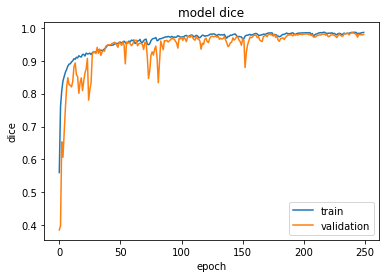

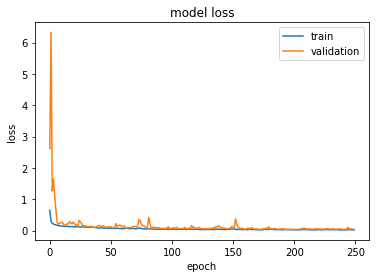

In [8]:
def show_plots(history):
    fig = plt.figure()
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model dice')
    plt.ylabel('dice')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    fig.savefig(os.path.join(save_imgs_dir,"dice-plot.png"))
    
    fig2 = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    fig2.savefig(os.path.join(save_imgs_dir,"loss-plot.png"))
    
show_plots(hist)

In [9]:
import tensorflow as tf

model_endo.load_weights(weight_file)

def calculate_dice(images, masks_true,model_in):
    dices = []
    masks_pred = np.concatenate([model_in.predict(image[None,:,:,:]) for image in images])
    for mask_true, mask_pred in zip(masks_true, masks_pred):
        y_true = mask_true[:,:,1].astype('uint8')
        y_pred = np.round(mask_pred[:,:,1]).astype('uint8')
        dices.append(dice_coef_np(y_true.flatten(), y_pred.flatten()))
    print("Dice Average: {:.2f} Dice Stdev: {:.2f}".format(np.mean(dices), np.std(dices)))

In [10]:
print("Training Statistics(No Dropout)...")
calculate_dice(train_images, train_inner_masks,model_endo)
print("Validation Statistics(No Dropout)...")
calculate_dice(validation_images, validation_inner_masks,model_endo)

Training Statistics(No Dropout)...
Dice Average: 0.82 Dice Stdev: 0.21
Validation Statistics(No Dropout)...
Dice Average: 0.67 Dice Stdev: 0.32


# View Predictions on Validation Set

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


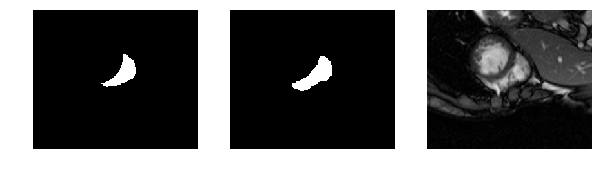

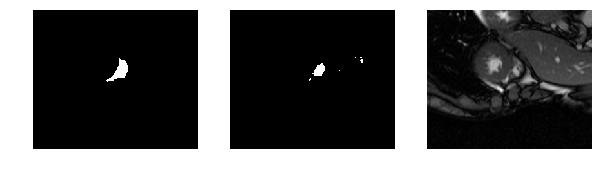

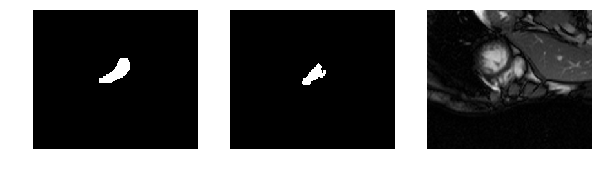

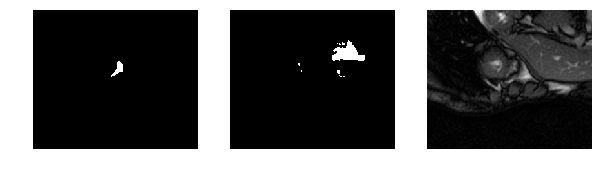

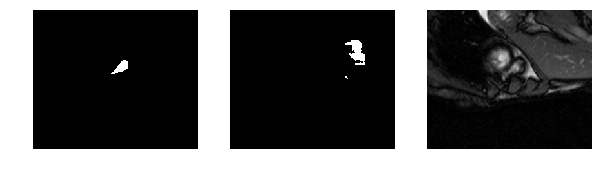

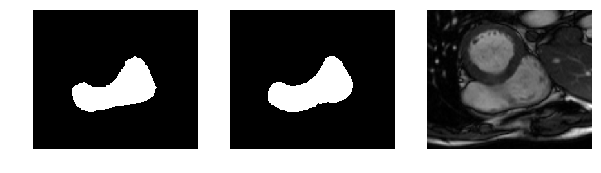

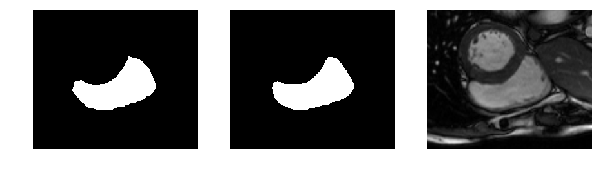

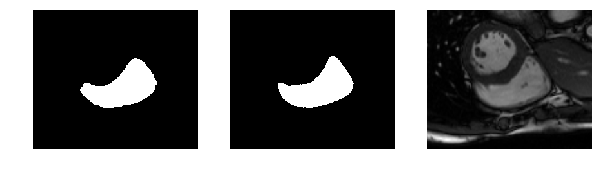

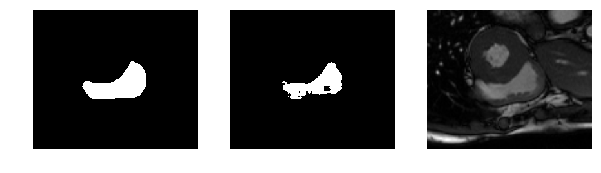

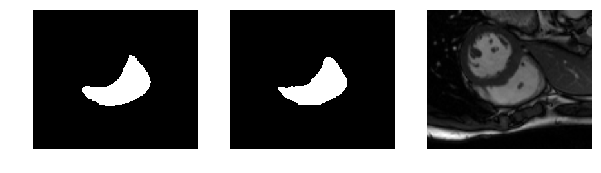

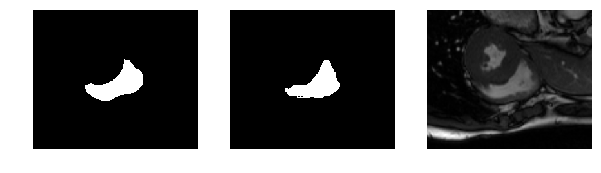

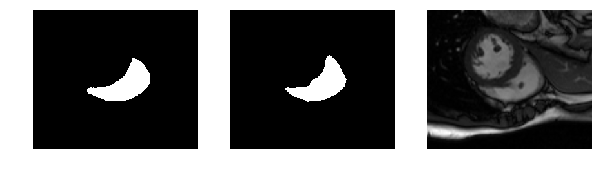

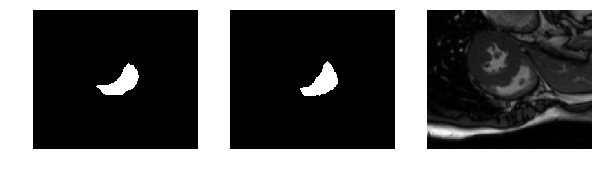

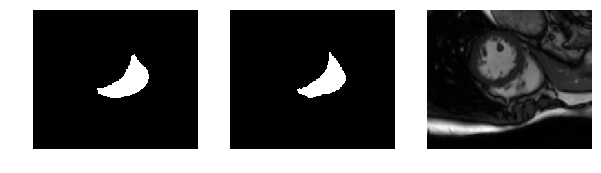

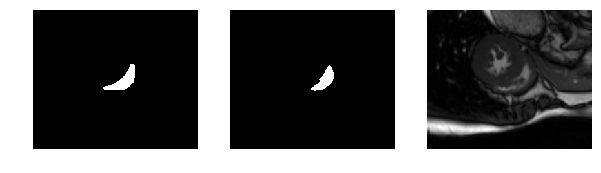

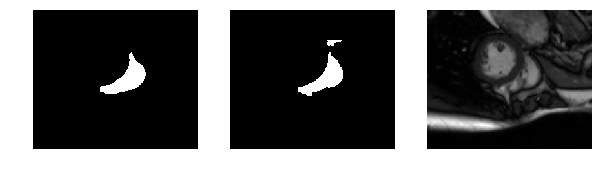

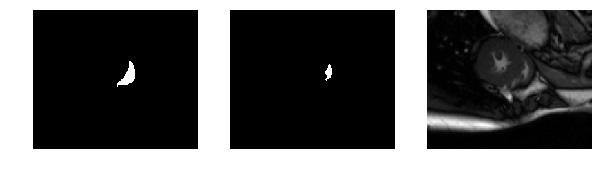

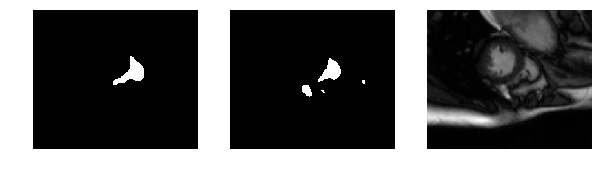

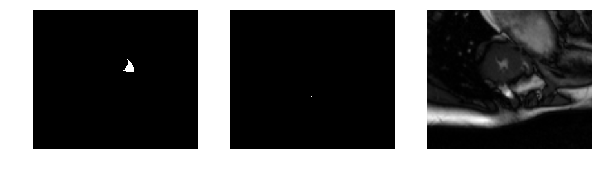

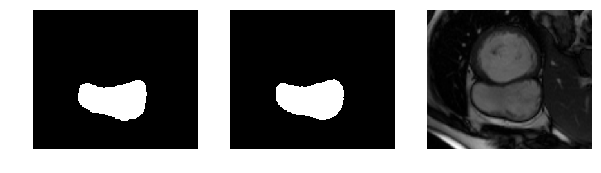

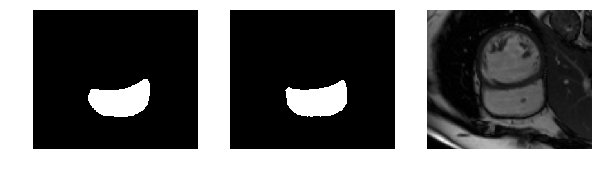

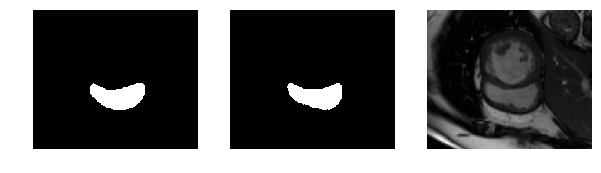

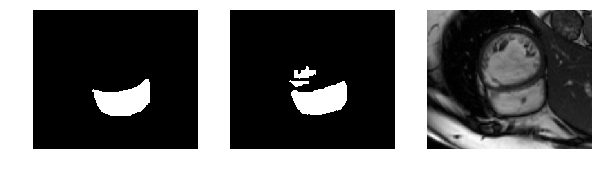

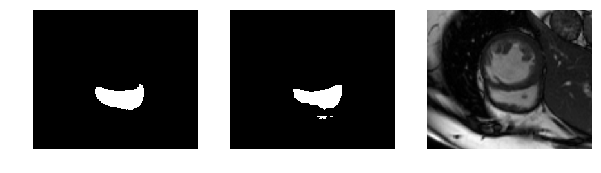

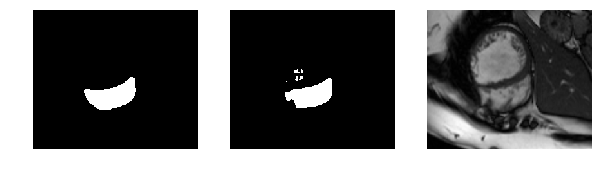

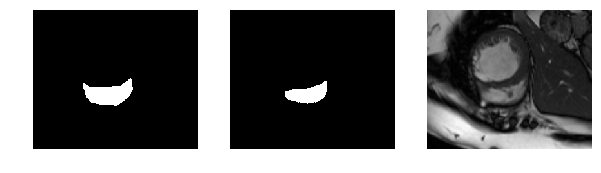

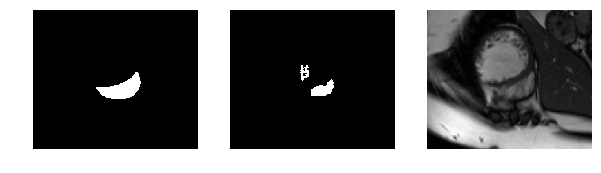

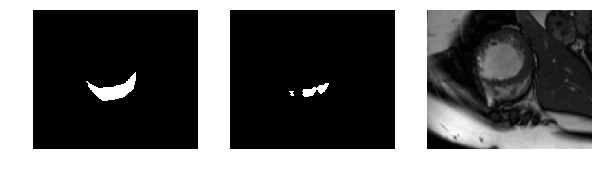

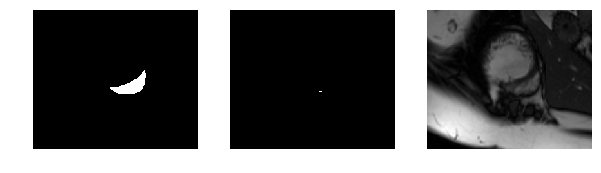

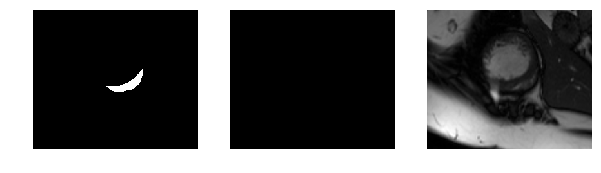

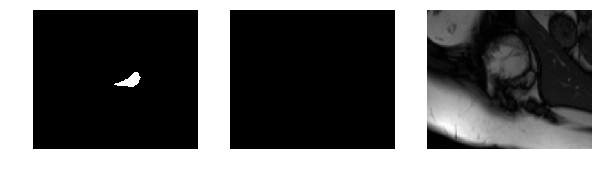

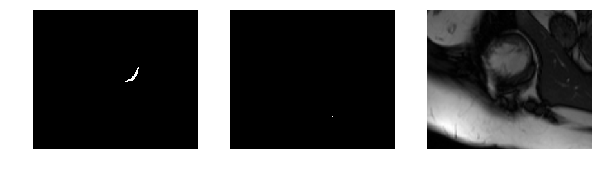

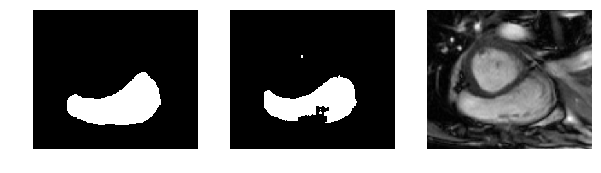

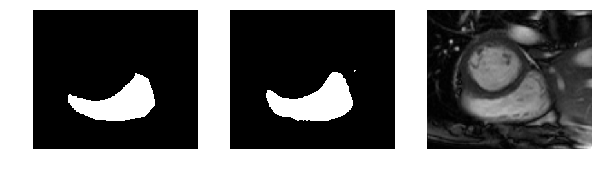

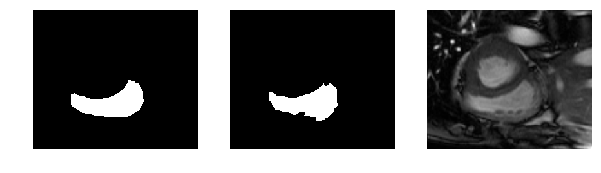

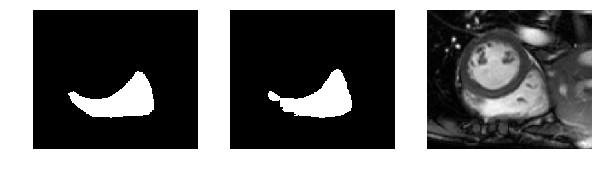

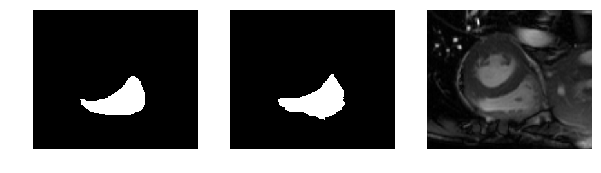

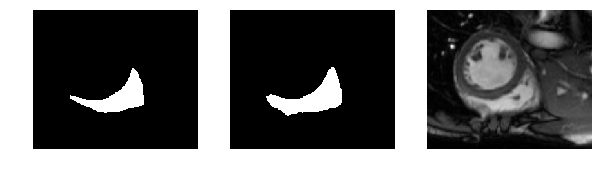

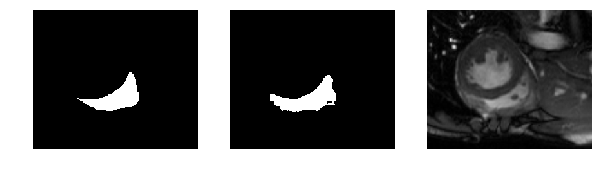

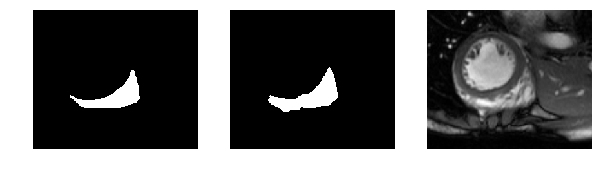

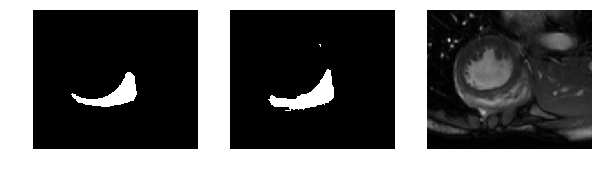

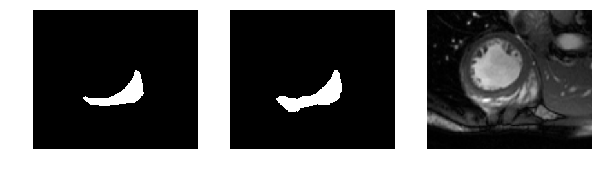

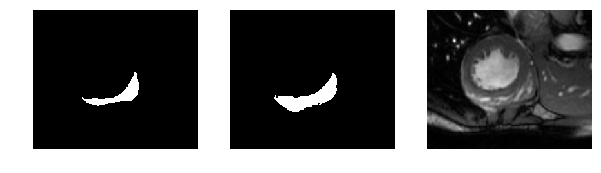

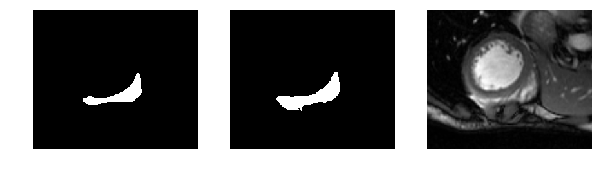

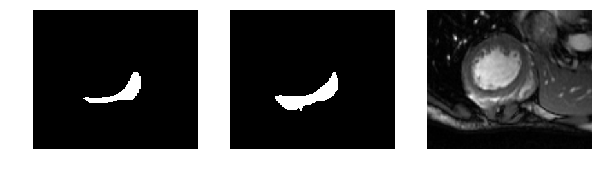

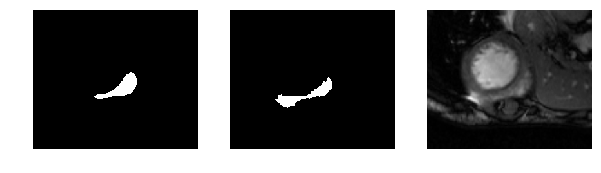

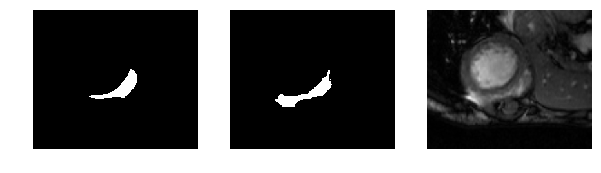

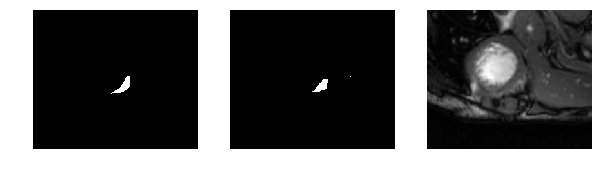

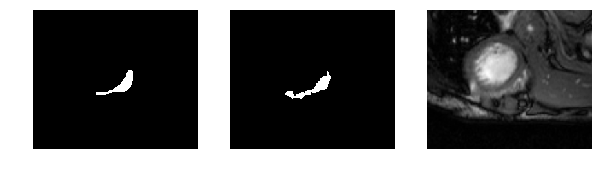

In [28]:
def show_masks(images, i_masks_true,model_in):
    masks_pred = np.concatenate([model_in.predict(image[None,:,:,:]) for image in images])
    counter = 0
    for (image,i_mask,mask_pred) in zip(images,i_masks_true,masks_pred):
        plt.figure(figsize=(10,5))
        plt.subplot(1, 3, 1)
        plt.axis("off")
        plt.imshow(i_mask, cmap=plt.cm.gray)
        plt.subplot(1,3,2)
        plt.axis("off")
        plt.imshow(np.where(mask_pred[:,:,1]>0.5,255,0),cmap=plt.cm.gray)
        plt.subplot(1, 3, 3)
        plt.axis("off")
        plt.imshow(image[:,:,0], cmap=plt.cm.gray)
        counter += 1
        filename = "{:2d}.png".format(counter)
        plt.savefig(os.path.join(save_imgs_dir, filename))
        
show_masks(images[split_index:], inner_masks[split_index:],model_endo)

# Epicardium Model Training

In [5]:
height,width,_ = images[0].shape
dropout=0.0

unet_conv_epi = unet.UNet()

model_epi = unet_conv_epi.get_unet(height=height, width=width, channels=1,features=32,steps=3,dropout=dropout,padding='same')
model_epi.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 216, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 216, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 216, 256, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 216, 256, 32) 0           activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
model_epi.compile(optimizer=Adam(lr=1e-3),loss=['binary_crossentropy'],metrics=[dice_coef])

In [7]:
train_images_datagen.fit(train_images,augment=True,seed=seed)
train_masks_datagen.fit(train_outer_masks,augment=True,seed=seed)

train_images_generator = train_images_datagen.flow(train_images, y=None, seed=seed)
train_masks_generator = train_images_datagen.flow(train_outer_masks, y=None, seed=seed)


train_generator = zip(train_images_generator, train_masks_generator)

/usr/local/lib/python3.5/dist-packages/Keras-2.1.3-py3.5.egg/keras/preprocessing/image.py:722: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
/usr/local/lib/python3.5/dist-packages/Keras-2.1.3-py3.5.egg/keras/preprocessing/image.py:896: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).


In [9]:
checkpointer_epi = ModelCheckpoint(filepath=epi_weight_file, verbose=1, save_best_only=True)

hist_epi = model_epi.fit_generator(train_generator,steps_per_epoch=train_steps,epochs=epochs,verbose=1,callbacks=[checkpointer_epi],
                   validation_data=(validation_images,validation_outer_masks),validation_steps=val_steps)

Epoch 1/250
6/7 [========================>.....] - ETA: 2s - loss: 0.5699 - dice_coef: 0.6542
Epoch 00001: val_loss improved from inf to 0.28674, saving model to saved_models/epi_models/weights-250Epochs-NoDrop-Adam3.hdf5
7/7 [==============================] - 16s 2s/step - loss: 0.5200 - dice_coef: 0.6811 - val_loss: 0.2867 - val_dice_coef: 0.8033
Epoch 2/250
6/7 [========================>.....] - ETA: 1s - loss: 0.2705 - dice_coef: 0.8192
Epoch 00002: val_loss improved from 0.28674 to 0.21807, saving model to saved_models/epi_models/weights-250Epochs-NoDrop-Adam3.hdf5
7/7 [==============================] - 7s 1s/step - loss: 0.2693 - dice_coef: 0.8272 - val_loss: 0.2181 - val_dice_coef: 0.8899
Epoch 3/250
6/7 [========================>.....] - ETA: 1s - loss: 0.2379 - dice_coef: 0.8689
Epoch 00003: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.2478 - dice_coef: 0.8629 - val_loss: 0.2238 - val_dice_coef: 0.8548
Epoch 4/250
6/7 [==================

Epoch 27/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1477 - dice_coef: 0.9062
Epoch 00027: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.1452 - dice_coef: 0.9078 - val_loss: 0.1567 - val_dice_coef: 0.9197
Epoch 28/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1475 - dice_coef: 0.9097
Epoch 00028: val_loss improved from 0.14982 to 0.14690, saving model to saved_models/epi_models/weights-250Epochs-NoDrop-Adam3.hdf5
7/7 [==============================] - 7s 1s/step - loss: 0.1386 - dice_coef: 0.9137 - val_loss: 0.1469 - val_dice_coef: 0.9092
Epoch 29/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1423 - dice_coef: 0.9102
Epoch 00029: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.1395 - dice_coef: 0.9108 - val_loss: 0.1765 - val_dice_coef: 0.9292
Epoch 30/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1524 - dice_coef: 0.9063
Epoch 00030: val_loss did no

Epoch 55/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1103 - dice_coef: 0.9340
Epoch 00055: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.1135 - dice_coef: 0.9312 - val_loss: 0.1286 - val_dice_coef: 0.9380
Epoch 56/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1190 - dice_coef: 0.9246
Epoch 00056: val_loss improved from 0.10594 to 0.10120, saving model to saved_models/epi_models/weights-250Epochs-NoDrop-Adam3.hdf5
7/7 [==============================] - 7s 1s/step - loss: 0.1174 - dice_coef: 0.9257 - val_loss: 0.1012 - val_dice_coef: 0.9374
Epoch 57/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1022 - dice_coef: 0.9382
Epoch 00057: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0979 - dice_coef: 0.9398 - val_loss: 0.1122 - val_dice_coef: 0.9390
Epoch 58/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1027 - dice_coef: 0.9402
Epoch 00058: val_loss did no

Epoch 84/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0737 - dice_coef: 0.9616
Epoch 00084: val_loss improved from 0.08565 to 0.08184, saving model to saved_models/epi_models/weights-250Epochs-NoDrop-Adam3.hdf5
7/7 [==============================] - 7s 1s/step - loss: 0.0721 - dice_coef: 0.9611 - val_loss: 0.0818 - val_dice_coef: 0.9564
Epoch 85/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0645 - dice_coef: 0.9603
Epoch 00085: val_loss improved from 0.08184 to 0.06655, saving model to saved_models/epi_models/weights-250Epochs-NoDrop-Adam3.hdf5
7/7 [==============================] - 7s 1s/step - loss: 0.0619 - dice_coef: 0.9616 - val_loss: 0.0665 - val_dice_coef: 0.9620
Epoch 86/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0589 - dice_coef: 0.9660
Epoch 00086: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0591 - dice_coef: 0.9657 - val_loss: 0.0809 - val_dice_coef: 0.9628
Epoch 87/250
6/7 [===========

Epoch 113/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0522 - dice_coef: 0.9675
Epoch 00113: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0533 - dice_coef: 0.9682 - val_loss: 0.0609 - val_dice_coef: 0.9683
Epoch 114/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0496 - dice_coef: 0.9704
Epoch 00114: val_loss improved from 0.05272 to 0.05137, saving model to saved_models/epi_models/weights-250Epochs-NoDrop-Adam3.hdf5
7/7 [==============================] - 7s 1s/step - loss: 0.0484 - dice_coef: 0.9706 - val_loss: 0.0514 - val_dice_coef: 0.9712
Epoch 115/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0475 - dice_coef: 0.9747
Epoch 00115: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0508 - dice_coef: 0.9725 - val_loss: 0.0706 - val_dice_coef: 0.9654
Epoch 116/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0526 - dice_coef: 0.9688
Epoch 00116: val_loss di

Epoch 174/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0363 - dice_coef: 0.9811
Epoch 00174: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0345 - dice_coef: 0.9815 - val_loss: 0.0507 - val_dice_coef: 0.9751
Epoch 175/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0328 - dice_coef: 0.9813
Epoch 00175: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0377 - dice_coef: 0.9787 - val_loss: 0.0428 - val_dice_coef: 0.9781
Epoch 176/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0325 - dice_coef: 0.9804
Epoch 00176: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0312 - dice_coef: 0.9812 - val_loss: 0.0414 - val_dice_coef: 0.9801
Epoch 177/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0325 - dice_coef: 0.9806
Epoch 00177: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0311 - dice_coef: 0.

Epoch 236/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0208 - dice_coef: 0.9876
Epoch 00236: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0202 - dice_coef: 0.9877 - val_loss: 0.0398 - val_dice_coef: 0.9833
Epoch 237/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0212 - dice_coef: 0.9877
Epoch 00237: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0211 - dice_coef: 0.9876 - val_loss: 0.0389 - val_dice_coef: 0.9833
Epoch 238/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0214 - dice_coef: 0.9871
Epoch 00238: val_loss improved from 0.03762 to 0.03618, saving model to saved_models/epi_models/weights-250Epochs-NoDrop-Adam3.hdf5
7/7 [==============================] - 7s 1s/step - loss: 0.0204 - dice_coef: 0.9876 - val_loss: 0.0362 - val_dice_coef: 0.9841
Epoch 239/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0208 - dice_coef: 0.9875
Epoch 00239: val_loss di

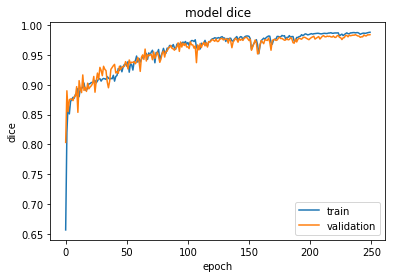

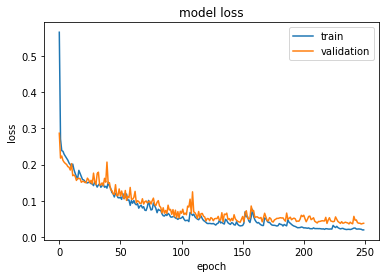

In [10]:
def show_plots(history):
    fig = plt.figure()
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model dice')
    plt.ylabel('dice')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    fig.savefig(os.path.join(save_imgs_dir_epi,"dice-plot.png"))
    
    fig2 = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    fig2.savefig(os.path.join(save_imgs_dir_epi,"loss-plot.png"))
    
show_plots(hist_epi)

In [17]:
import tensorflow as tf

model_epi.load_weights(epi_weight_file)

def calculate_dice(images, masks_true,model_in):
    dices = []
    masks_pred = np.concatenate([model_in.predict(image[None,:,:,:]) for image in images])
    for mask_true, mask_pred in zip(masks_true, masks_pred):
        y_true = mask_true[:,:,1].astype('uint8')
        y_pred = np.round(mask_pred[:,:,1]).astype('uint8')
        dices.append(dice_coef_np(y_true.flatten(), y_pred.flatten()))
    print("Dice Average: {:.2f} Dice Stdev: {:.2f}".format(np.mean(dices), np.std(dices)))

In [18]:
print("Training Statistics(No Dropout)...")
calculate_dice(train_images, train_outer_masks,model_epi)
print("Validation Statistics(No Dropout)...")
calculate_dice(validation_images, validation_outer_masks,model_epi)

Training Statistics(No Dropout)...
Dice Average: 0.90 Dice Stdev: 0.14
Validation Statistics(No Dropout)...
Dice Average: 0.77 Dice Stdev: 0.29


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


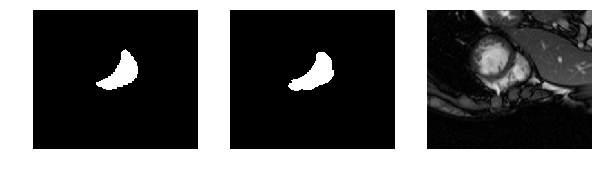

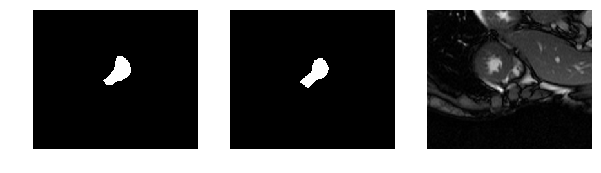

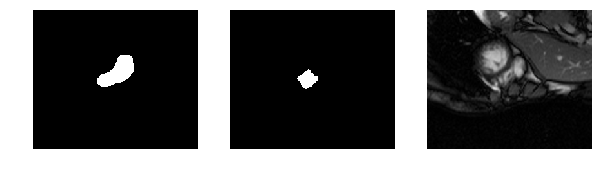

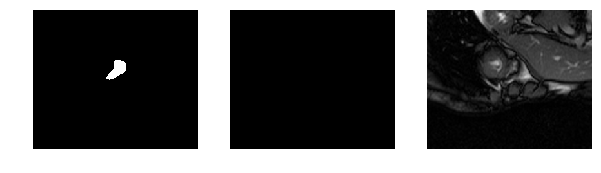

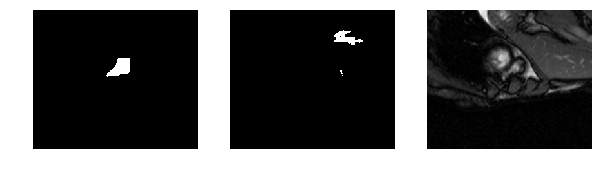

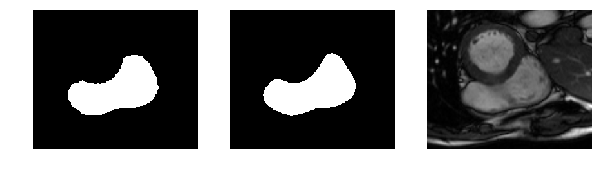

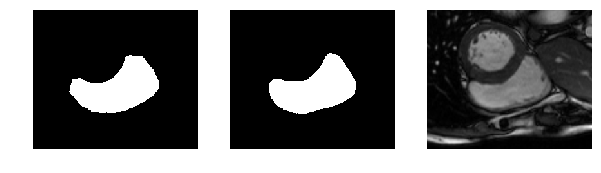

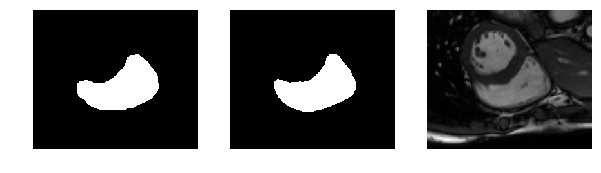

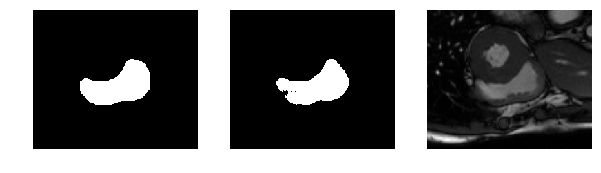

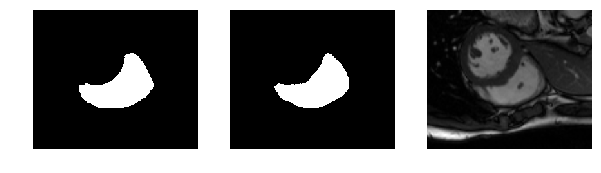

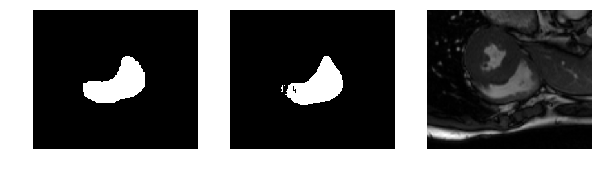

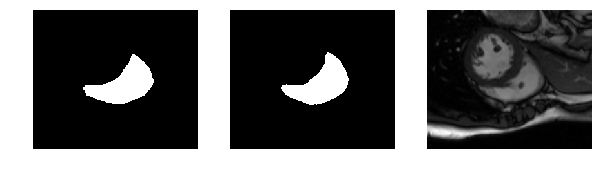

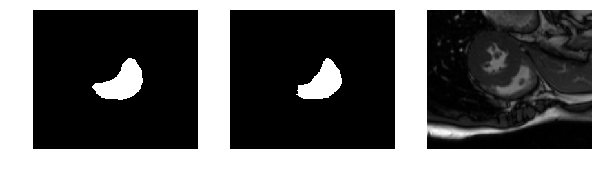

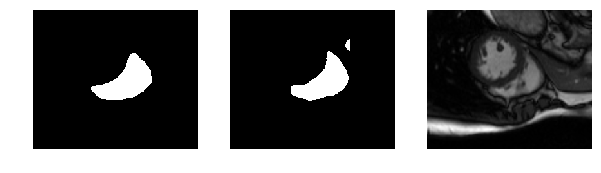

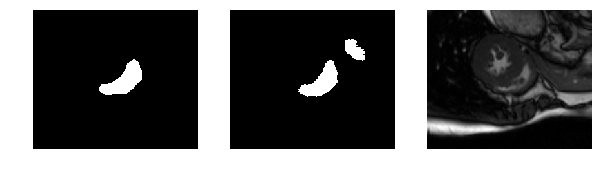

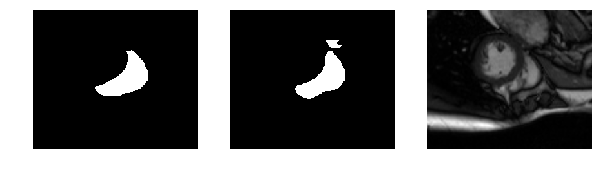

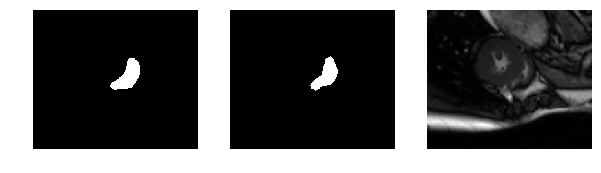

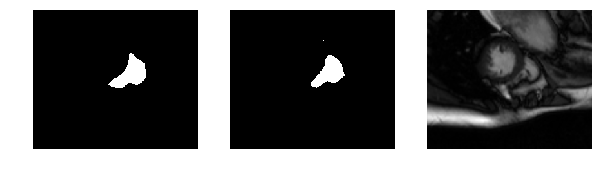

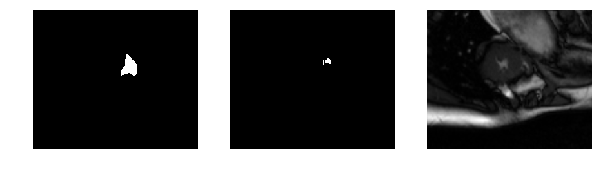

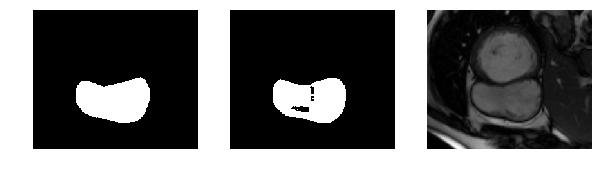

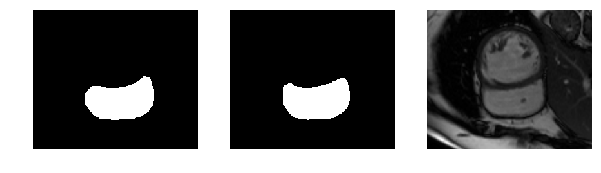

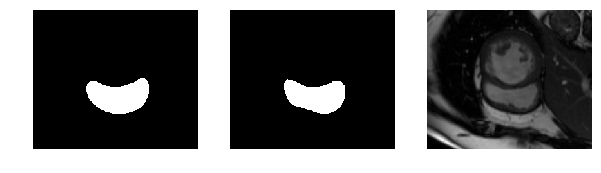

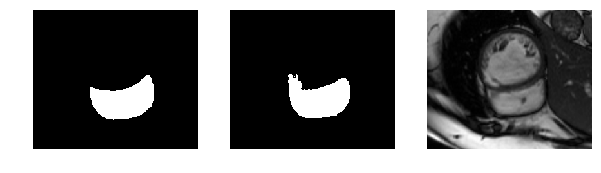

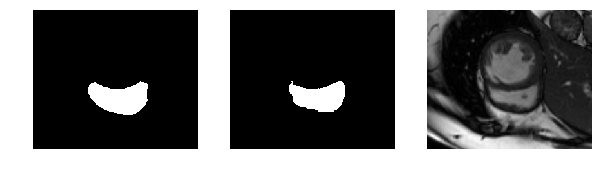

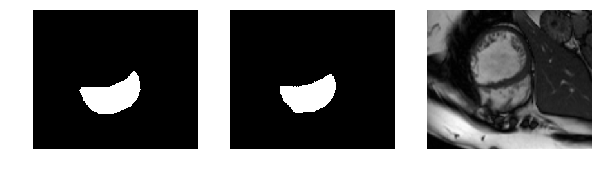

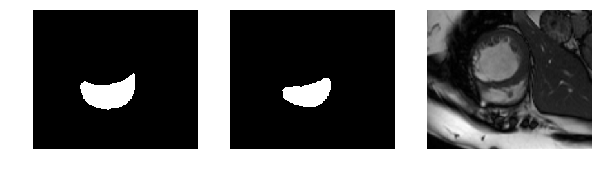

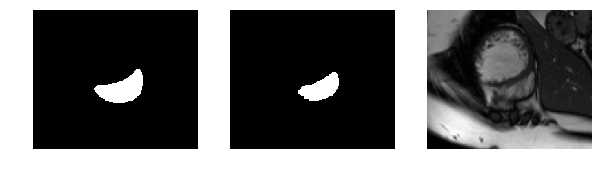

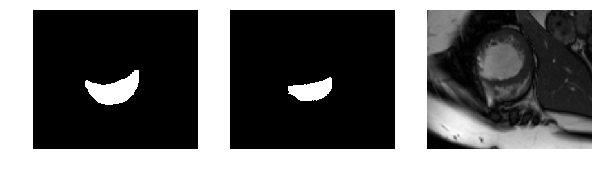

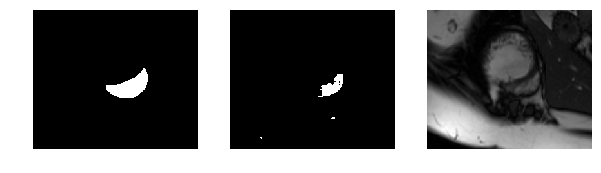

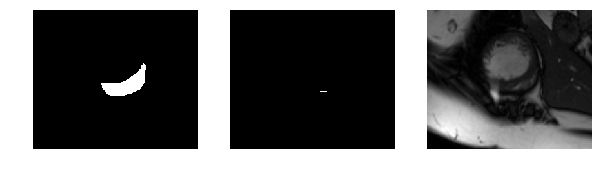

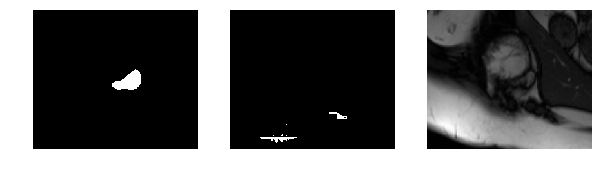

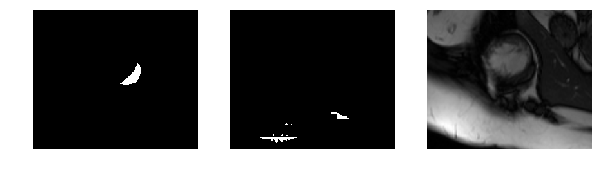

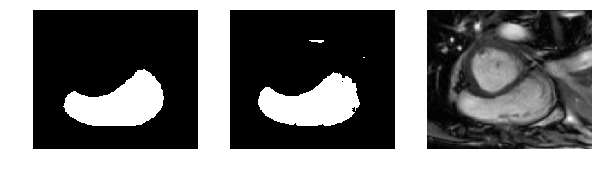

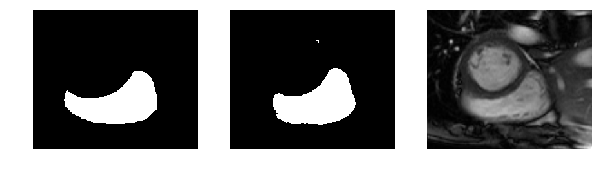

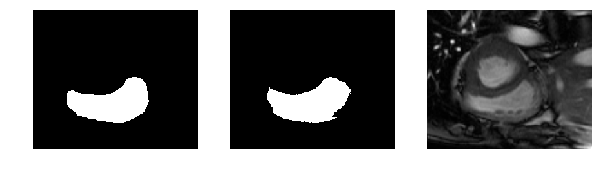

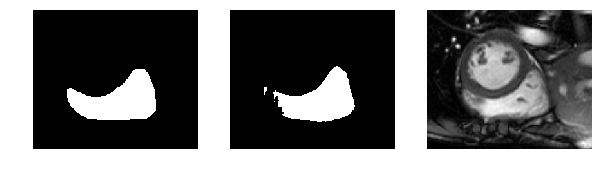

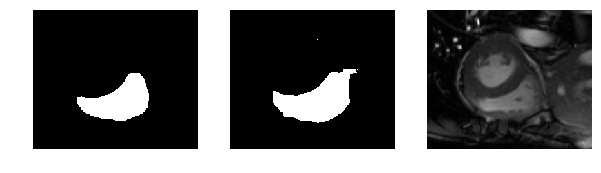

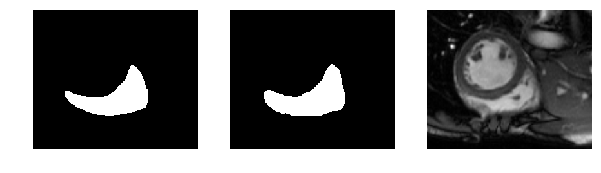

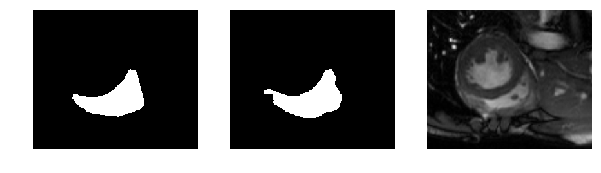

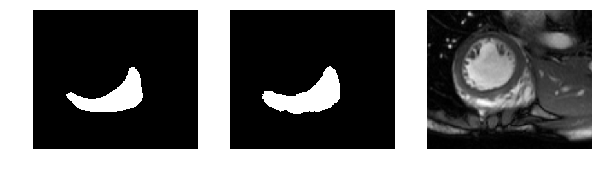

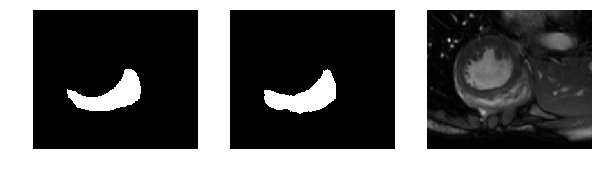

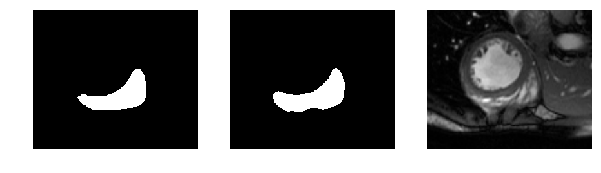

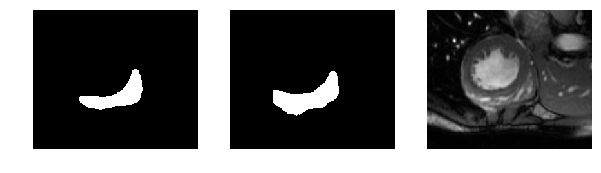

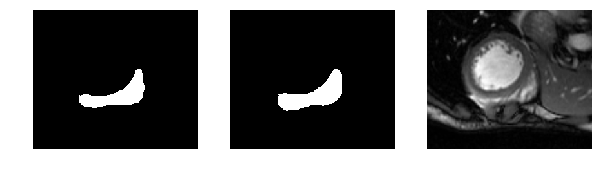

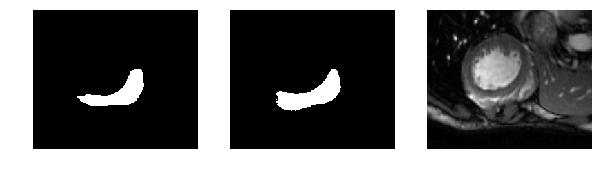

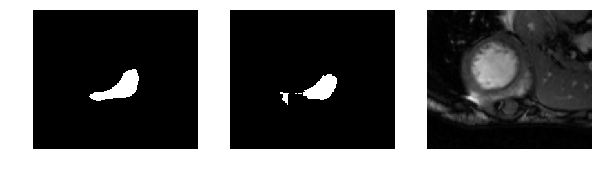

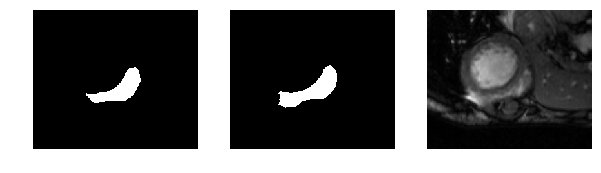

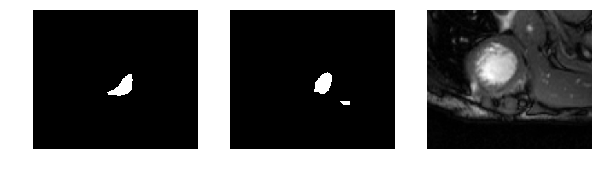

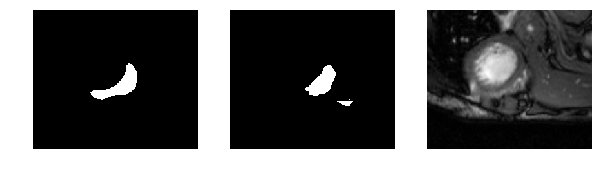

In [21]:
def show_masks(images, i_masks_true,model_in):
    masks_pred = np.concatenate([model_in.predict(image[None,:,:,:]) for image in images])
    counter = 0
    for (image,i_mask,mask_pred) in zip(images,i_masks_true,masks_pred):
        plt.figure(figsize=(10,5))
        plt.subplot(1, 3, 1)
        plt.axis("off")
        plt.imshow(i_mask, cmap=plt.cm.gray)
        plt.subplot(1,3,2)
        plt.axis("off")
        plt.imshow(np.round(mask_pred[:,:,1]),cmap=plt.cm.gray)
        plt.subplot(1, 3, 3)
        plt.axis("off")
        plt.imshow(image[:,:,0], cmap=plt.cm.gray)
        counter += 1
        filename = "{:2d}.png".format(counter)
        plt.savefig(os.path.join(save_imgs_dir_epi, filename))
        
show_masks(images[split_index:], outer_masks[split_index:],model_epi)